# **12장 – 텐서플로를 사용한 사용자 정의 모델과 훈련**

- 텐서플로를 자세히 들어다보고 저수준 파이썬 API를 알아봅니다.
- 손실함수, 지표, 층, 모델, 초기화, 규제, 가중치 규제 등을 만들어 세부적으로 제어
- 그레디언트에 특별한 변환, 규제를 만들어서, 반복문 자체 제어
- 자동 그래프 생성기능을 만들어서 사용자 정의 모델 및 훈련 알고리즘 성능 향상

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/12_custom_models_and_training_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [241]:
import sys
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
assert sys.version_info >= (3, 7)

# # 코랩의 경우, 해당주석을 풀고 진행하세요 나눔 폰트를 설치합니다.
# import sys
# if 'google.colab' in sys.modules:
#     !sudo apt-get -qq -y install fonts-nanum
#     import matplotlib.font_manager as fm
#     font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
#     for fpath in font_files:
#         fm.fontManager.addfont(fpath)
# matplotlib.rc('font', family='NanumBarunGothic')

# 나눔 폰트를 사용합니다.
import matplotlib
matplotlib.rc('font', family='malgun gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

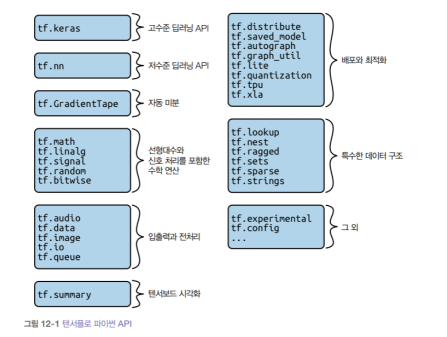

## 넘파이처럼 텐서플로 사용하기
- 텐서플로는 넘파이와 유사한 API를 제공하여 데이터 과학자들이 익숙한 방식으로 작업할 수 있게 합니다.

### 텐서 및 연산
- 텐서는 텐서플로의 기본 데이터 구조로, 다차원 배열을 표현합니다.

#### 텐서
- 텐서는 스칼라, 벡터, 행렬 및 더 높은 차원의 배열을 포함할 수 있습니다.

In [242]:
t = tf.constant([[1, 2., 3.], [4., 5., 6.]]) # 행렬
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [243]:
t.shape

TensorShape([2, 3])

In [244]:
t.dtype

tf.float32

#### 인덱싱
- 넘파이와 유사하게 텐서에서도 인덱싱과 슬라이싱이 가능합니다.

In [245]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [6]:
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [7]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

#### 연산
- 텐서플로는 텐서 간의 다양한 수학적 연산을 지원합니다.

In [246]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [9]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [247]:
tf.transpose(t)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 4.],
       [2., 5.],
       [3., 6.]], dtype=float32)>

In [10]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

#### 스칼라
- 0차원 텐서로, 단일 값을 나타냅니다.

In [248]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

#### 케라스의 저수준 API

- 케라스는 더 이상 멀티 백엔드를 지원하지 않지만, 텐서플로의 저수준 API를 직접 사용할 수 있습니다.

In [249]:
K = tf.keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

In [13]:
tf.square(tf.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 텐서와 넘파이
- 텐서플로와 넘파이 간의 상호 변환이 가능하여 두 라이브러리를 함께 사용할 수 있습니다.

In [252]:
import numpy as np

a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [256]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [259]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [17]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [260]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 타입 변환
- 텐서플로에서는 타입 불일치를 엄격하게 처리하므로, 필요한 경우 명시적으로 타입을 변환해야 합니다.

In [262]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [263]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float32)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

In [266]:
tf.constant(2.0) + tf.constant(40., dtype=tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

In [21]:
# t2 = tf.constant(40., dtype=tf.float64)
# tf.constant(2.0) + tf.cast(t2, tf.float32)

### 변수
- 변수는 모델의 파라미터를 저장하는 데 사용되며, 값을 변경할 수 있는 특별한 종류의 텐서입니다.

In [288]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [289]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [290]:
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [291]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [294]:
v.scatter_nd_update(
    indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,   5.,   6.],
       [  1.,   2., 200.]], dtype=float32)>

In [300]:
# 추가 코드 - scatter_update() 사용 방법을 보여줍니다.
sparse_delta = tf.IndexedSlices(values=[[10., 20., 30.], [40., 50., 60.]],
                                indices=[1, 0])
sparse_delta

In [301]:
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

In [302]:
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[40., 50., 60.],
       [10., 20., 30.]], dtype=float32)>

In [28]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


### 문자열

- 텐서플로는 문자열 데이터를 처리하기 위한 특별한 기능을 제공합니다.

In [303]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [304]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [305]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [306]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [307]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

### 다른 데이터 구조

- 텐서플로는 기본 텐서 외에도 다양한 특수 데이터 구조를 지원합니다.

#### 문자열 배열
- 문자열로 구성된 배열을 효율적으로 처리할 수 있습니다.

In [308]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [309]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [310]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [311]:
b = tf.strings.unicode_encode(u, "UTF-8")
b

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [312]:
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [313]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [314]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])
p

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'Caf\xc3\xa9', b'Coffee', b'caff\xc3\xa8',
       b'\xe5\x92\x96\xe5\x95\xa1'], dtype=object)>

In [315]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [316]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

#### 래그드 텐서
- 불규칙한 형태의 데이터를 표현할 수 있는 특별한 종류의 텐서입니다.

In [318]:
r[1]

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([ 67, 111, 102, 102, 101, 101])>

In [321]:
r[1:3]  # 추가 코드 - 래그드 텐서의 슬라이스는 래그드 텐서입니다.

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>

In [324]:
r2 = tf.ragged.constant([[65, 66], [], [67]])


In [325]:
tf.concat([r, r2], axis=0)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>

In [326]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])


In [327]:
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71],
 [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [330]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]])>

#### 희소 텐서
- 대부분의 요소가 0인 큰 텐서를 효율적으로 표현할 수 있습니다.

In [48]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [331]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [332]:
s * 42.0

In [333]:
try:
    s + 42.0
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [334]:
# 추가 코드 - 희소 텐서와 밀집 텐서를 곱하는 방법을 보여줍니다.
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [339]:
# 추가 코드 - 희소 텐서를 생성할 때 값을 "읽는 순서"로 제공해야 하며, 그렇지 않으면 `to_dense()`가 실패합니다.
s5 = tf.SparseTensor(indices=[[1, 1], [0, 2]],  # 잘못된 순서!
                     values=[1., 2.],
                     dense_shape=[3, 4])
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

{{function_node __wrapped__SparseToDense_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,2] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [54]:
# 추가 코드 - 희소 텐서 s5의 값을 재정렬하여 수정하는 방법을 보여줍니다.
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

#### 텐서 배열
- 텐서의 리스트 : 고정된 길이를 가지지만 동적으로 바꿀수 있음

In [345]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array

In [346]:
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))
tensor2 = array.read(2)  # tf.constant([3., 10.])을 반환하고 (0으로 채웁니다!)
tensor2 

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([5., 7.], dtype=float32)>

In [347]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.,  2.],
       [ 3., 10.],
       [ 0.,  0.]], dtype=float32)>

In [355]:
# 추가 코드 - clear_after_read를 비활성화하는 방법을 보여줍니다.
array2 = tf.TensorArray(dtype=tf.float32, size=3, clear_after_read=False)
array2 = array2.write(0, tf.constant([1., 2.]))
array2 = array2.write(1, tf.constant([3., 10.]))
array2 = array2.write(2, tf.constant([5., 7.]))
tensor2 = array2.read(1)  # tf.constant([3., 10.])를 반환합니다.
array2.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.,  2.],
       [ 3., 10.],
       [ 5.,  7.]], dtype=float32)>

In [356]:
# 추가 코드 - 동적 크기의 텐서 배열을 생성하고 사용하는 방법을 보여줍니다.
array3 = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
array3 = array3.write(0, tf.constant([1., 2.]))
array3 = array3.write(1, tf.constant([3., 10.]))
array3 = array3.write(2, tf.constant([5., 7.]))
tensor3 = array3.read(1)
array3.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

#### 집합
- 텐서플로에서 집합 연산을 수행할 수 있습니다.

In [357]:
a = tf.constant([[1, 5, 9]])
b = tf.constant([[5, 6, 9, 11]])
u = tf.sets.union(a, b)
u

In [358]:
tf.sparse.to_dense(u)

<tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[ 1,  5,  6,  9, 11]])>

In [61]:
a = tf.constant([[1, 5, 9], [10, 0, 0]])
b = tf.constant([[5, 6, 9, 11], [13, 0, 0, 0]])
u = tf.sets.union(a, b)
tf.sparse.to_dense(u)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [ 0, 10, 13,  0,  0]])>

In [62]:
# 추가 코드 - 다른 기본값(이 경우 -1)을 사용하는 방법을 보여줍니다.
a = tf.constant([[1, 5, 9], [10, -1, -1]])
b = tf.constant([[5, 6, 9, 11], [13, -1, -1, -1]])
u = tf.sets.union(a, b)
tf.sparse.to_dense(u, default_value=-1)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [-1, 10, 13, -1, -1]])>

In [63]:
# 추가 코드 - `tf.sets.difference()`를 사용하는 방법을 보여줍니다.
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]])>

In [64]:
# 추가 코드 - `tf.sets.difference()`를 사용하는 방법을 보여줍니다.
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]])>

In [65]:
# 추가 코드 - set1[0]에 5가 포함되어 있는지 확인합니다.
tf.sets.size(tf.sets.intersection(set1[:1], tf.constant([[5, 0, 0, 0]]))) > 0

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>

#### 큐
- 데이터 스트림을 처리하거나 배치 작업을 수행할 때 유용한 FIFO(First In First Out) 큐를 제공합니다.

In [359]:
q = tf.queue.FIFOQueue(3, [tf.int32, tf.string], shapes=[(), ()])
q.enqueue([10, b"windy"])
q.enqueue([15, b"sunny"])
q.size()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [360]:
q.dequeue()

[<tf.Tensor: shape=(), dtype=int32, numpy=10>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'windy'>]

In [361]:
q.enqueue_many([[13, 16], [b'cloudy', b'rainy']])

In [362]:
q.dequeue_many(3)

[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([15, 13, 16])>,
 <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'sunny', b'cloudy', b'rainy'], dtype=object)>]

## 사용자 정의 손실
- 손실 함수는 모델의 예측과 실제 목표값 사이의 차이를 측정합니다. 사용자 정의 손실 함수를 만들면 특정 문제에 더 적합한 손실을 정의할 수 있습니다.

In [70]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

#### 후버손실 함수
- 후버 손실은 평균 제곱 오차(MSE)와 평균 절대 오차(MAE)의 장점을 결합한 함수입니다. 작은 오차에 대해서는 MSE처럼, 큰 오차에 대해서는 MAE처럼 동작합니다.

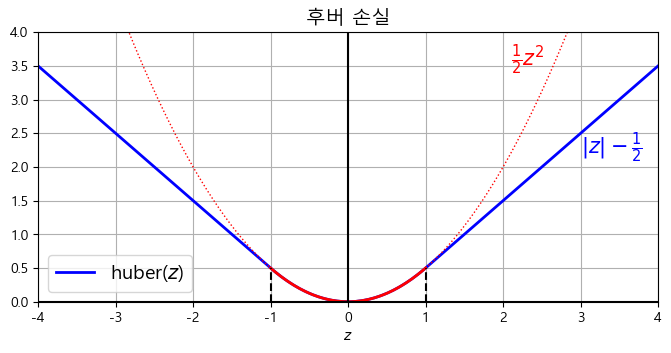

In [363]:
# 추가 코드 - 후버 손실의 모습을 보여줍니다.
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("후버 손실", fontsize=14)
plt.show()

사용자 정의 손실 함수를 테스트하기 위해 기본 케라스 모델을 만들고 캘리포니아 주택 데이터셋으로 훈련해 보겠습니다:

In [364]:
# 추가 코드 - 캘리포니아 주택 데이터셋을 로드, 분할 및 스케일을 조정한 다음 간단한 케라스 모델을 생성합니다.

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, 
    housing.target.reshape(-1, 1), 
    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, 
    y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", 
                          kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [365]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [366]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4827 - mae: 0.8318 - val_loss: 0.3478 - val_mae: 0.6525
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2411 - mae: 0.5412 - val_loss: 0.2641 - val_mae: 0.5484


## 사용자 정의 요소를 가진 모델을 저장하고 로드하기
- 사용자 정의 요소가 포함된 모델을 저장하고 나중에 로드할 때는 추가적인 단계가 필요합니다. 이 섹션에서는 그 방법을 설명합니다.

In [373]:
help(model)

Help on Sequential in module keras.engine.sequential object:

class Sequential(keras.engine.functional.Functional)
 |  Sequential(layers=None, name=None)
 |  
 |  `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
 |  
 |  `Sequential` provides training and inference features on this model.
 |  
 |  Examples:
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = tf.keras.Sequential()
 |  model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
 |  # Afterwards, we do automatic shape inference:
 |  model.add(tf.keras.layers.Dense(4))
 |  
 |  # This is identical to the following:
 |  model = tf.keras.Sequential()
 |  model.add(tf.keras.Input(shape=(16,)))
 |  model.add(tf.keras.layers.Dense(8))
 |  
 |  # Note that you can also omit the `input_shape` argument.
 |  # In that case the model doesn't have any weights until the first call
 |  # to a training/evaluation method (since it isn't yet built):
 |  model = tf.keras.S

In [367]:
model.save("models/my_model_with_a_custom_loss")  # 추가 코드 - 정상적으로 저장됩니다.

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss\assets


INFO:tensorflow:Assets written to: my_model_with_a_custom_loss\assets


In [368]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

In [369]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2050 - mae: 0.4906 - val_loss: 0.2199 - val_mae: 0.4934
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1885 - mae: 0.4677 - val_loss: 0.2025 - val_mae: 0.4775


In [370]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [371]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [372]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2049 - mae: 0.4594 - val_loss: 0.2229 - val_mae: 0.4561
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1977 - mae: 0.4527 - val_loss: 0.2056 - val_mae: 0.4533


In [81]:
model.save("my_model_with_a_custom_loss_threshold_2")

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss_threshold_2\assets


In [82]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_threshold_2",
                                   custom_objects={"huber_fn": create_huber(2.0)})

In [83]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1933 - mae: 0.4460 - val_loss: 0.1988 - val_mae: 0.4385
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1895 - mae: 0.4420 - val_loss: 0.1871 - val_mae: 0.4391


In [84]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [85]:
# 추가 코드 - 간단한 케라스 모델을 또 하나 생성합니다.
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [86]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [87]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6454 - mae: 0.8438 - val_loss: 0.5095 - val_mae: 0.6720
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2910 - mae: 0.5549 - val_loss: 0.3744 - val_mae: 0.5699


In [88]:
model.save("my_model_with_a_custom_loss_class")  # 추가 코드 - 정상 저장

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss_class\assets


In [89]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_class",
                                   custom_objects={"HuberLoss": HuberLoss})

In [90]:
# 추가 코드 - 정상적으로 로드되고 모델을 정상적으로 사용할 수 있음을 보여줍니다.
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2415 - mae: 0.5031 - val_loss: 0.2906 - val_mae: 0.5044
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2171 - mae: 0.4771 - val_loss: 0.2530 - val_mae: 0.4856


In [91]:
model.loss.threshold  # 추가 코드 - threshold가 올바르게 로드되었습니다.

2.0

## 기타 사용자 정의 기능
- 손실 함수 외에도 활성화 함수, 초기화 함수, 규제화 함수 등 다양한 요소를 사용자 정의할 수 있습니다. 이를 통해 모델의 유연성을 크게 높일 수 있습니다.

In [92]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):  # 반환 값은 tf.nn.relu(weights)입니다.
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [374]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

In [94]:
# 추가 코드 - 사용자 정의 요소가 많이 포함된 모델을 빌드, 훈련, 저장, 로드, 훈련할 수 있습니다.

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.4686 - mae: 0.8298 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.8104 - mae: 0.6168 - val_loss: 2.5983 - val_mae: 0.6052
INFO:tensorflow:Assets written to: my_model_with_many_custom_parts\assets
Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6324 - mae: 0.5611 - val_loss: 1.1383 - val_mae: 0.5456
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5566 - mae: 0.5299 - val_loss: 1.0250 - val_mae: 0.5246


In [95]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {"factor": self.factor}

In [96]:
# 추가 코드 - 이번에는 사용자 정의 규제 클래스를 사용하는 경우 정상적으로 작동하는지 보여줍니다.

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_regularizer=MyL1Regularizer(0.01),
                          kernel_constraint=my_positive_weights,
                          kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.4686 - mae: 0.8298 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.8104 - mae: 0.6168 - val_loss: 2.5983 - val_mae: 0.6052
INFO:tensorflow:Assets written to: my_model_with_many_custom_parts\assets
Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6324 - mae: 0.5611 - val_loss: 1.1383 - val_mae: 0.5456
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5566 - mae: 0.5299 - val_loss: 1.0250 - val_mae: 0.5246


## 사용자 정의 지표
- 지표는 모델의 성능을 평가하는 데 사용됩니다. 사용자 정의 지표를 만들면 특정 문제에 더 적합한 평가 방법을 정의할 수 있습니다.

In [97]:
# 추가 코드 - 다시 한 번 기본 케라스 모델을 만들어 보겠습니다.
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [98]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [99]:
# 추가 코드 - 사용자 정의 지표로 모델 훈련하기
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.7450 - huber_fn: 0.6825
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.7879 - huber_fn: 0.3138


**노트**: 동일한 함수를 손실과 지표로 사용하면 약간 다른 결과에 놀랄 수 있습니다. 이는 부분적으로 연산이 정확히 같은 순서로 계산되지 않아 미세한 부동 소수점 오류가 발생할 수 있기 때문입니다. 더 중요한 것은 샘플 가중치 또는 클래스 가중치를 사용하는 경우 방정식이 약간 달라진다는 것입니다:
* `fit()` 메서드는 에포크 시작 이후 지금까지 본 모든 배치 손실의 평균을 추적합니다. 각 배치 손실은 가중치가 적용된 샘플 손실의 합을 _배치 크기_로 나눈 값입니다. (가중치의 합으로 나눈 것이 아니므로 배치 손실은 손실의 가중 평균이 _아니다_.).
* 에포크 시작 이후의 지표는 가중치가 적용된 샘플 손실의 합을 지금까지 본 모든 가중치의 합으로 나눈 값과 같습니다. 즉, 모든 샘플 손실의 가중 평균입니다. 위와 같지 않습니다.

### 스트리밍 지표
- 스트리밍 지표는 전체 데이터셋을 메모리에 로드하지 않고도 점진적으로 계산할 수 있는 지표입니다. 대규모 데이터셋을 다룰 때 유용합니다.

In [385]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [383]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.36363637>

In [377]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [103]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [104]:
precision.reset_states()

Creating a streaming metric:

In [386]:
recall = tf.keras.metrics.Recall()
recall([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [387]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)  # 기본 매개변수 처리 (예를 들어, dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**추가 자료** – 이 섹션의 나머지 부분에서는 `HuberMetric` 클래스를 테스트하고 `tf.keras.metrics.Mean`를 서브클래싱하는 또 다른 예를 보여줍니다.

In [388]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [107]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [389]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [390]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=14.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=1.0>]

In [391]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

`HuberMetric` 클래스가 제대로 작동하는지 확인해 보겠습니다:

In [392]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", 
                          kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [395]:
model.compile(loss=create_huber(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

In [396]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 929us/step - loss: 0.6454 - huber_metric_5: 0.6454
Epoch 2/2
363/363 [==============================] - 0s 944us/step - loss: 0.2910 - huber_metric_5: 0.2910


In [397]:
model.save("my_model_with_a_custom_metric")

INFO:tensorflow:Assets written to: my_model_with_a_custom_metric\assets


INFO:tensorflow:Assets written to: my_model_with_a_custom_metric\assets


In [398]:
model = tf.keras.models.load_model(
    "my_model_with_a_custom_metric",
    custom_objects={
        "huber_fn": create_huber(2.0),
        "HuberMetric": HuberMetric
    }
)

In [116]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 933us/step - loss: 0.2415 - huber_metric_1: 0.2415
Epoch 2/2
363/363 [==============================] - 0s 933us/step - loss: 0.2171 - huber_metric_1: 0.2171


`model.metrics`은 모델 손실 다음에 모델의 지표를 담고 있으므로 `HuberMetric`은 `model.metrics[-1]`입니다:

In [117]:
model.metrics[-1].threshold

2.0

잘 작동하는 것 같습니다! 더 간단하게는 다음과 같이 클래스를 만들 수도 있습니다:

In [399]:
class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

이 클래스는 크기를 더 잘 처리하며 샘플 가중치도 지원합니다.

In [119]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [120]:
model.compile(loss=tf.keras.losses.Huber(2.0), optimizer="nadam",
              weighted_metrics=[HuberMetric(2.0)])

In [121]:
np.random.seed(42)
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2,
                    sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.3252 - HuberMetric: 0.6553
Epoch 2/2
363/363 [==============================] - 0s 979us/step - loss: 0.1446 - HuberMetric: 0.2915


In [122]:
(history.history["loss"][0],
 history.history["HuberMetric"][0] * sample_weight.mean())

(0.3251718282699585, 0.3251719045631172)

In [123]:
model.save("my_model_with_a_custom_metric_v2")

INFO:tensorflow:Assets written to: my_model_with_a_custom_metric_v2\assets


In [124]:
model = tf.keras.models.load_model("my_model_with_a_custom_metric_v2",
                                   custom_objects={"HuberMetric": HuberMetric})

In [125]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 950us/step - loss: 0.2438 - HuberMetric: 0.2438
Epoch 2/2
363/363 [==============================] - 0s 972us/step - loss: 0.2181 - HuberMetric: 0.2181


In [126]:
model.metrics[-1].threshold

2.0

## 사용자 정의 층
- 케라스에서 제공하는 기본 층 외에도 사용자가 직접 새로운 층을 정의할 수 있습니다. 이를 통해 특정 문제에 맞는 고유한 연산을 수행하는 층을 만들 수 있습니다.

In [400]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [402]:
# 추가 코드 - 다른 층과 마찬가지로 함수로 사용할 수 있습니다:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

회귀 모델의 출력에 지수 층을 추가하면 예측할 값이 양수이고 스케일이 매우 다른 경우(예: 0.001, 10., 10000) 유용할 수 있습니다.

In [403]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7784 - val_loss: 0.4393
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5702 - val_loss: 0.4094
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4431 - val_loss: 0.3760
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4984 - val_loss: 0.3785
Epoch 5/5
162/162 [==============================] - 0s 740us/step - loss: 0.3781


0.3781099021434784

또는 타깃을 타깃의 로그로 대체하고 출력 층에서 활성화 함수를 사용하지 않는 것이 더 나을 수 있습니다.

In [404]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [131]:
# 추가 코드 - 사용자 정의 층을 보통처럼 사용할 수 있음을 보여줍니다.
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)
model.save("my_model_with_a_custom_layer")

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 3.1061 - val_loss: 7.1579
Epoch 2/2
162/162 [==============================] - 0s 756us/step - loss: 0.7029
INFO:tensorflow:Assets written to: my_model_with_a_custom_layer\assets


In [132]:
# 추가 코드 - 사용자 정의 층을 가진 모델을 로드하는 방법을 보여줍니다.
model = tf.keras.models.load_model("my_model_with_a_custom_layer",
                                   custom_objects={"MyDense": MyDense})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.5935 - val_loss: 0.5097
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.4701 - val_loss: 0.5948


In [133]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  # extra code
        return X1 + X2, X1 * X2, X1 / X2

사용자 정의 층은 다음과 같이 함수형 API를 사용하여 호출할 수 있습니다:

In [134]:
# 추가 코드 - 심볼릭 입력으로 MyMultiLayer를 테스트합니다.
inputs1 = tf.keras.layers.Input(shape=[2])
inputs2 = tf.keras.layers.Input(shape=[2])
MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>)

`call()` 메서드는 심볼릭 입력을 받고 심볼릭 출력을 반환한다는 점에 유의하세요. 이 단계에서는 부분적인 크기만 지정합니다. 배치 크기를 알 수 없기 때문에 첫 번째 차원이 `None`입니다.

실제 데이터를 사용자 정의 층에 전달할 수도 있습니다:

In [135]:
# 추가 코드 - 실제 데이터로 MyMultiLayer를 테스트합니다.
X1, X2 = np.array([[3., 6.], [2., 7.]]), np.array([[6., 12.], [4., 3.]])
MyMultiLayer()((X1, X2))

X1.shape:  (2, 2)  X2.shape:  (2, 2)


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 9., 18.],
        [ 6., 10.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[18., 72.],
        [ 8., 21.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5      , 0.5      ],
        [0.5      , 2.3333333]], dtype=float32)>)

이제 훈련과 테스트 중에 다르게 동작하는 층을 만들어 보겠습니다:

In [405]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

다음은 이 사용자 정의 층을 사용하는 간단한 모델입니다:

In [406]:
# 추가 코드 - MyGaussianNoise 테스트
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    MyGaussianNoise(stddev=1.0, input_shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.2197 - val_loss: 25.3956
Epoch 2/2
162/162 [==============================] - 0s 821us/step - loss: 1.1056


1.1055991649627686

## 사용자 정의 모델
- 전체 모델 구조를 사용자가 직접 정의할 수 있습니다. 이는 복잡한 아키텍처나 특별한 훈련 로직이 필요한 경우에 유용합니다.

In [407]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [408]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [409]:
# 추가 코드 - 모델을 정상적으로 사용할 수 있음을 보여줍니다.
tf.keras.utils.set_random_seed(42)
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)
model.save("my_custom_model")

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 30.7726
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 1.0908


INFO:tensorflow:Assets written to: my_custom_model\assets


INFO:tensorflow:Assets written to: my_custom_model\assets


In [141]:
# 추가 코드 - 모델을 로드하고 훈련을 계속하거나 이를 사용하여 예측을 수행할 수 있습니다.
model = tf.keras.models.load_model("my_custom_model")
history = model.fit(X_train_scaled, y_train, epochs=2)
model.predict(X_test_scaled[:3])

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.9173
Epoch 2/2
1/1 [==============================] - 0s 118ms/step


array([[1.0191149],
       [1.5131273],
       [4.2167306]], dtype=float32)

대신 시퀀셜 API를 사용하여 모델을 정의할 수도 있습니다:

In [411]:
tf.keras.utils.set_random_seed(42)
block1 = ResidualBlock(2, 30)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    tf.keras.layers.Dense(1)
])

## 모델 구성 요소에 기반한 손실과 지표

**경고**: TF 2.2의 문제([#46858](https://github.com/tensorflow/tensorflow/issues/46858))로 인해 `super().build()`가 실패합니다. 대신 `self.built = True`를 설정하여 이 문제를 해결할 수 있습니다.

In [412]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(
            name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)
        self.built = True  # super().build(batch_input_shape)에 대한 해결 방법

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [413]:
# 추가 코드
tf.keras.utils.set_random_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
y_pred = model.predict(X_test_scaled)

Epoch 1/5
363/363 [==============================] - 2s 1ms/step - loss: 0.7936 - reconstruction_error: 1.0617
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4678 - reconstruction_error: 0.5440
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4157 - reconstruction_error: 0.3934
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3876 - reconstruction_error: 0.3524
Epoch 5/5
162/162 [==============================] - 0s 799us/step


## 자동 미분을 사용해 그레이디언트 계산하기
- 텐서플로의 자동 미분 기능을 사용하면 복잡한 함수의 그레이디언트를 쉽게 계산할 수 있습니다. 이는 사용자 정의 훈련 루프를 구현할 때 특히 유용합니다.

In [414]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [415]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [416]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [418]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [419]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [420]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # 텐서 36.0를 반환합니다.
try:
    dz_dw2 = tape.gradient(z, w2)  # RuntimeError가 발생합니다!
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [421]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # 텐서 36.0를 반환합니다.
dz_dw2 = tape.gradient(z, w2)  # 텐서 10.0을 반환하고 이제 정상적으로 작동합니다!
del tape

In [422]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [423]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [154]:
gradients

[None, None]

In [424]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [425]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [426]:
# 추가 코드 - 벡터가 주어지면 tape.gradient()를 사용해 벡터의 합의 그레이디언트을 계산합니다.
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [427]:
# 추가 코드 - 이전 셀과 동일한 결과를 얻었음을 보여줍니다.
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    z = z1 + z2 + z3

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [428]:
# 추가 코드 - 야코비안과 헤시안을 계산하는 방법을 보여줍니다.
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [429]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [430]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [431]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  # stop_gradient()를 사용하지 않은 경우와 동일한 결과

gradients = tape.gradient(z, [w1, w2])

In [432]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [433]:
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

In [434]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [435]:
x = tf.Variable([1.0e30])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]

In [436]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

다음은 이 방정식이 log(1 + exp(_z_))와 같다는 것을 증명하는 예입니다:
* softplus(_z_) = log(1 + exp(_z_))
* softplus(_z_) = log(1 + exp(_z_)) - log(exp(_z_)) + log(exp(_z_)) ; **같은 값을 더하고 뺍니다**
* softplus(_z_) = log\[(1 + exp(_z_)) / exp(_z_)\] + log(exp(_z_)) ; **since log(_a_) - log(_b_) = log(_a_ / _b_)**
* softplus(_z_) = log\[(1 + exp(_z_)) / exp(_z_)\] + _z_ ; **since log(exp(_z_)) = _z_**
* softplus(_z_) = log\[1 / exp(_z_) + exp(_z_) / exp(_z_)\] + _z_ ; **since (1 + _a_) / _b_ = 1 / _b_ + _a_ / _b_**
* softplus(_z_) = log\[exp(–_z_) + 1\] + _z_ ; **1 / exp(_z_) = exp(–z)이고 exp(_z_) / exp(_z_) = 1 이므로**
* softplus(_z_) = softplus(–_z_) + _z_ ; **맨 위의 정의를 사용합니다. 다만 –_z_ 입니다**
* softplus(_z_) = softplus(–|_z_|) + max(0, _z_) ; **_z_ < 0 나 _z_ ≥ 0 인 경우를 고려하면**

In [437]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = 상위 층에서 역전파된 그레이디언트
        return grads * (1 - 1 / (1 + tf.exp(z)))  # 안정적인 소프트플러스 그레이디언트

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [438]:
# 추가 코드 - 함수와 이 함수의 그레이디언트가 안정적임을 보여줍니다.
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

## 사용자 정의 훈련
- 기본 fit() 메서드 대신 사용자 정의 훈련 루프를 구현할 수 있습니다. 이를 통해 훈련 과정을 완전히 제어할 수 있습니다.

In [440]:
tf.keras.utils.set_random_seed(42)  # 추가 코드 - 재현성 보장
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [441]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [442]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

In [443]:
tf.keras.utils.set_random_seed(42)

In [444]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [445]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # 추가 코드 - 모델 변수에 제약이 있는 경우
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
362/362 - mean: 3.5419 - mean_absolute_error: 0.6640
Epoch 2/5
362/362 - mean: 1.8693 - mean_absolute_error: 0.5431
Epoch 3/5
362/362 - mean: 1.1428 - mean_absolute_error: 0.5030
Epoch 4/5
362/362 - mean: 0.8501 - mean_absolute_error: 0.4977
Epoch 5/5
362/362 - mean: 0.7280 - mean_absolute_error: 0.5014


In [446]:
# 추가 코드 - tqdm 패키지를 사용하여 멋진 진행률 표시줄을 표시하는 방법을 보여줍니다.

from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## 텐서플로 함수
- @tf.function 데코레이터를 사용하면 파이썬 함수를 텐서플로 그래프로 변환할 수 있습니다. 이는 성능을 향상시키고 모델을 저장하고 배포하는 데 도움이 됩니다.

In [447]:
def cube(x):
    return x ** 3

In [448]:
cube(2)

8

In [449]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [450]:
tf_cube = tf.function(cube)
tf_cube

In [451]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [452]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [453]:
@tf.function
def tf_cube(x):
    return x ** 3

**노트:** 이 섹션의 나머지 코드는 부록 D의 내용입니다.

### TF 함수와 콘크리트 함수

In [454]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function

<ConcreteFunction tf_cube(x) at 0x2A15A81D160>

In [455]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [456]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### 함수 정의와 그래프 탐험하기

In [457]:
concrete_function.graph

In [458]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [459]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [460]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [461]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [462]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [463]:
concrete_function.function_def.signature

name: "__inference_tf_cube_951679"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### TF 함수가 파이썬 함수를 트레이싱하여 계산 그래프를 추출하는 방법

In [464]:
@tf.function
def tf_cube(x):
    print(f"x = {x}")
    return x ** 3

In [465]:
result = tf_cube(tf.constant(2.0))

x = Tensor("x:0", shape=(), dtype=float32)


In [466]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [467]:
result = tf_cube(2)

x = 2


In [468]:
result = tf_cube(3)

x = 3


In [469]:
result = tf_cube(tf.constant([[1., 2.]]))  # 새로운 크기: 트레이싱!

x = Tensor("x:0", shape=(1, 2), dtype=float32)


In [470]:
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))  # 새로운 크기: 트레이싱!

x = Tensor("x:0", shape=(2, 2), dtype=float32)


In [471]:
result = tf_cube(tf.constant([[7., 8.], [9., 10.]]))  # 같은 크기: 트레이싱 없음

It is also possible to specify a particular input signature:

In [472]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)  # 트레이싱을 출력하는 추가 코드
    return images[:, ::2, ::2] # 행과 열의 절반을 삭제합니다.

In [473]:
tf.keras.utils.set_random_seed(42)

In [474]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1)  # 정상 작동, 함수 트레이싱
preprocessed_images = shrink(img_batch_2)  # 정상 작동, 동일한 콘크리트 함수

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [476]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # ValueError! 호환되지 않는 입력
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7402308  0.33938193]
  [0.5692506  0.44811392]]

 [[0.29285502 0.4260056 ]
  [0.62890387 0.691061  ]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


### Autograph를 사용해 제어 흐름 표현하기

`range()`를 사용하는 "정적" `for` 루프입니다:

In [477]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [478]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [479]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

`tf.while_loop()`를 사용하는 "동적" 루프입니다:

In [480]:
# 추가 코드 - tf.while_loop를 사용하는 방법을 보여줍니다(일반적으로 @tf.function이 더 간단합니다).
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [481]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [482]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

(autograph가 감지한) `tf.range()`를 사용하는 "동적" `for` 루프:

In [483]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [484]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### TF 함수에서 변수와 다른 리소스 다루기

In [485]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

increment(counter)  # counter는 이제 1과 같습니다.
increment(counter)  # counter는 이제 2와 같습니다.

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [486]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [487]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [488]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [489]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [490]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [491]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [492]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [493]:
# 추가 코드 - 구문 강조 표시로 autograph 코드를 표시하는 방법을 보여줍니다.
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown(f'```python\n{code}\n```'))

In [494]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## 케라스에 TF 함수 사용하기(또는 사용하지 않기)

- 기본적으로 tf.keras는 사용자 지정 코드를 TF 함수로 자동 변환하므로 `tf.function()`을 사용할 필요가 없습니다:
- 케라스는 기본적으로 사용자 정의 코드를 TF 함수로 자동 변환합니다. 하지만 때로는 이 기능을 비활성화하고 동적 실행을 사용하는 것이 디버깅에 도움이 될 수 있습니다.


In [495]:
# 사용자 정의 손실 함수
def my_mse(y_true, y_pred):
    print("손실 my_mse() 트레이싱")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [496]:
# 사용자 정의 지표 함수
def my_mae(y_true, y_pred):
    print("지표 my_mae() 트레이싱")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [497]:
# 사용자 정의 층
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias',
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("MyDense.call() 트레이싱")
        return self.activation(X @ self.kernel + self.biases)

In [498]:
tf.keras.utils.set_random_seed(42)

In [499]:
# 사용자 정의 모델
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("MyModel.call() 트레이싱")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [500]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [501]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
304/363 [========================>.....] - ETA: 0s - loss: 1.5009 - my_mae: 0.8491MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
363/363 [==============================] - 1s 1ms/step - loss: 1.3362 - my_mae: 0.7919 - val_loss: 0.4376 - val_my_mae: 0.4720
Epoch 2/2
162/162 [==============================] - 0s 849us/step - loss: 0.4154 - my_mae: 0.4624


[0.4153972864151001, 0.46235308051109314]

이 기능은 `dynamic=True`로 모델을 생성하거나 모델 생성자에서 `super().__init__(dynamic=True, **kwargs)`를 호출하여 해제할 수 있습니다:

In [503]:
tf.keras.utils.set_random_seed(42)

In [504]:
model = MyModel(dynamic=True)

In [505]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

이제 사용자 정의 코드가 각 반복마다 호출됩니다. 너무 많은 출력을 피하기 위해 작은 데이터셋으로 검증과 평가를 수행해 보겠습니다:

In [506]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱


[5.545023441314697, 2.0603489875793457]

또는 `run_eagerly=True`로 모델을 컴파일할 수 있습니다:

In [235]:
tf.keras.utils.set_random_seed(42)

In [236]:
model = MyModel()

In [237]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [238]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
손실 my_mse() 트레이싱
지표 my_mae() 트레이싱


[5.545023441314697, 2.0603489875793457]

## 추가 자료 - 사용자 정의 옵티마이저

사용자 정의 옵티마이저를 정의하는 것은 그리 일반적이지 않지만, 만약 여러분이 옵티마이저를 작성해야 한다면 다음 예시를 참고하세요:

In [239]:
class MyMomentumOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.0, name="MyMomentumOptimizer", **kwargs):
        super().__init__(name, **kwargs)
        self._learning_rate = self._build_learning_rate(learning_rate)
        self.momentum = momentum

    def build(self, var_list):
        """옵티마이저 변수 초기화
        매개변수:
          var_list: 모델 변수 목록
        """
        super().build(var_list)
        if hasattr(self, "_built") and self._built:
            return
        self.momentums = []
        for var in var_list:
            self.momentums.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="m"
                )
            )
        self._built = True

    def update_step(self, gradient, variable):
        """주어진 그레이디언트와 관련된 모델 변수로 스텝을 업데이트합니다."""
        lr = tf.cast(self.learning_rate, variable.dtype)
        m = None
        var_key = self._var_key(variable)
        momentum = tf.cast(self.momentum, variable.dtype)
        m = self.momentums[self._index_dict[var_key]]

        if isinstance(gradient, tf.IndexedSlices):
            # 희소한 그레이디언트
            add_value = tf.IndexedSlices(
                -gradient.values * lr, gradient.indices
            )
            if m is not None:
                m.assign(m * momentum)
                m.scatter_add(add_value)
                variable.assign_add(m)
            else:
                variable.scatter_add(add_value)
        else:
            # 밀집 그레이디언트
            if m is not None:
                m.assign(-gradient * lr + m * momentum)
                variable.assign_add(m)
            else:
                variable.assign_add(-gradient * lr)

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter(self._learning_rate),
            "momentum": self._serialize_hyperparameter(self.momentum),
        }

In [240]:
optimizer = MyMomentumOptimizer()

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=optimizer)
model.fit(X_train_scaled, y_train, epochs=5)

AttributeError: 'MyMomentumOptimizer' object has no attribute '_build_learning_rate'

케라스에 내장된 모멘텀 옵티마이저와 비교해 보죠.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=optimizer)
model.fit(X_train_scaled, y_train, epochs=5)

# 연습문제 해답

## 1. to 11.

부록 A 참조

## 12. _층 정규화_ 를 수행하는 사용자 정의 층을 구현하세요.

_15장에서 순환 신경망을 사용할 때 이런 종류의 층을 사용합니다._

### a.
_문제: `build()` 메서드에서 두 개의 훈련 가능한 가중치 *α*와 *β*를 정의합니다. 두 가중치 모두 크기가 `input_shape[-1:]`이고 데이터 타입은 `tf.float32`입니다. *α*는 1로 초기화되고 *β*는 0으로 초기화되어야 합니다._

솔루션: 아래 참조.

### b.
_문제: `call()` 메서드는 샘플의 특성마다 평균 μ와 표준편차 σ를 계산해야 합니다. 이를 위해 전체 샘플의 평균 μ와 분산 σ<sup>2</sup>을 반환하는 `tf.nn.moments(inputs, axes=-1, keepdims=True)`을 사용할 수 있습니다(분산의 제곱근으로 표준편차를 계산합니다). 그다음 *α*⊗(*X* - μ)/(σ + ε) + *β*를 계산하여 반환합니다. 여기에서 ⊗는 원소별
곱셈(`*`)을 나타냅니다. ε은 안전을 위한 항입니다(0으로 나누어지는 것을 막기 위한 작은 상수. 예를 들면 0.001)._

In [ ]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # 반드시 끝에 와야 합니다

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

_ε_ 하이퍼파라미터(`eps`)는 필수가 아닙니다. 또한 `tf.sqrt(variance) + self.eps` 보다 `tf.sqrt(variance + self.eps)`를 계산하는 것이 좋습니다. sqrt(z)의 도함수는 z=0에서 정의되지 않기 때문에 분산 벡터의 한 원소가 0에 가까우면 훈련이 이리저리 널뜁니다. 제곱근 안에 _ε_를 넣으면 이런 현상을 방지할 수 있습니다.

### c.
_문제: 사용자 정의 층이 `tf.keras.layers.LayerNormalization` 층과 동일한(또는 거의 동일한) 출력을 만드는지 확인하세요._

각 클래스의 객체를 만들고 데이터(예를 들면, 훈련 세트)를 적용해 보죠. 차이는 무시할 수 있는 수준입니다.

In [ ]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = tf.keras.layers.LayerNormalization()

tf.reduce_mean(tf.keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

네 충분히 가깝네요. 조금 더 확실하게 알파와 베타를 완전히 랜덤하게 지정하고 다시 비교해 보죠:

In [ ]:
tf.keras.utils.set_random_seed(42)
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(tf.keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

여전히 무시할 수 있는 수준입니다! 사용자 정의 층이 잘 동작합니다.

## 13. 사용자 정의 훈련 반복을 사용해 패션 MNIST 데이터셋으로 모델을 훈련해보세요.

_패션 MNIST 데이터셋은 10장에서 소개했습니다._

### a.
_문제: 에포크, 반복, 평균 훈련 손실, (반복마다 업데이트되는) 에포크의 평균 정확도는 물론 에포크 끝에서 검증 손실과 정확도를 출력하세요._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


### b.
_문제: 상위 층과 하위 층에 학습률이 다른 옵티마이저를 따로 사용해보세요._

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
lower_layers = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
])
upper_layers = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="softmax"),
])
model = tf.keras.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()